# Sparse Hebbian Learning: basics

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.

Here, we will show the basic operations that are implemented in this package. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10

homeo_method = 'HEH'
tag = 'quantization'

matname = tag + '_' + homeo_method
opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, homeo_method=homeo_method, eta_homeo=0.05, alpha_homeo=0.02, C=5., nb_quant=128, P_cum=None, verbose=verbose)

In [4]:
from shl_scripts.shl_experiments import SHL
shl = SHL(**opts)
data = shl.get_data(matname='quantization')

Extracting data..No cache found data_cache/quantization_data: Extracting data... Extracting data..bird08.png, yellowleaves39.png, rocky10.png, bittern62.png, flowerhill29.png, clouds43.png, goldwater67.png, calcoast09.png, yose05.png, woods54.png, koala52.png, bora04.png, flowers37.png, yose07.png, cattails70.png, hibiscus30.png, cucorn50.png, geyser27.png, reflection63.png, craterlake12.png, Data is of shape : (81920, 144) - done in 10.95s.
Data is of shape : (81920, 144) - done in 11.62s.


In [5]:
!ls -l {shl.data_cache}/{tag}*

-rw-r--r--  1 lolo  staff  94371968 Feb 21 16:32 data_cache/quantization_data.npy


In [6]:
!ls -l {shl.data_cache}/{matname}*

ls: data_cache/quantization_HEH*: No such file or directory


In [7]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (81920, 144)
average of patches =  -1.5845357615905582e-05  +/-  0.008061093893545403
average energy of data =  0.05804771717773831 +/- 0.06573472852238083


In [8]:
shl.do_precision

False

## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

No cache found data_cache/quantization_HEH_dico.pkl: Learning the dictionary with algo = mp 
 Training on 81920 patches... Learning code... Iteration   1 /   8193 (elapsed time:   3s,   0mn   3s)
Iteration  129 /   8193 (elapsed time:  281s,   4mn  41s)
Iteration  257 /   8193 (elapsed time:  543s,   9mn   3s)
Iteration  385 /   8193 (elapsed time:  837s,  13mn  57s)
Iteration  513 /   8193 (elapsed time:  1133s,  18mn  53s)
Iteration  641 /   8193 (elapsed time:  1425s,  23mn  45s)
Iteration  769 /   8193 (elapsed time:  1716s,  28mn  36s)
Iteration  897 /   8193 (elapsed time:  2022s,  33mn  42s)
Iteration  1025 /   8193 (elapsed time:  2327s,  38mn  47s)
Iteration  1153 /   8193 (elapsed time:  2634s,  43mn  54s)
Iteration  1281 /   8193 (elapsed time:  2943s,  49mn   3s)
Iteration  1409 /   8193 (elapsed time:  3252s,  54mn  12s)
Iteration  1537 /   8193 (elapsed time:  3563s,  59mn  23s)
Iteration  1665 /   8193 (elapsed time:  3872s,  64mn  32s)
Iteration  1793 /   8193 (elapsed 

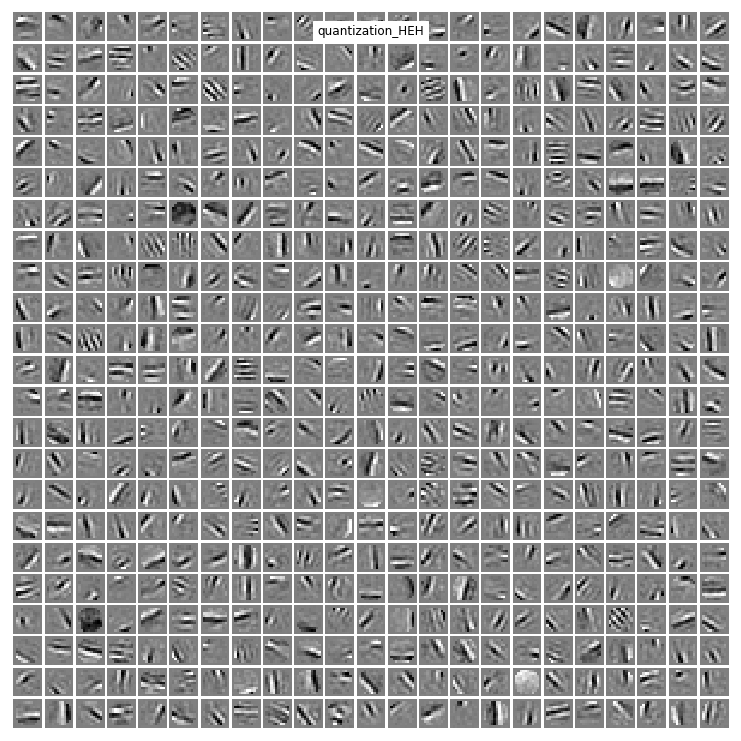

In [9]:
list_figures = ['show_dico']#, 'time_plot_error', 'time_plot_aerror']#, 'plot_variance',  'plot_variance_histogram',  'time_plot_prob',  'time_plot_kurt',  'time_plot_var']

dico = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [10]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico.dictionary.shape)
print('average of filters = ',  dico.dictionary.mean(axis=1).mean(), 
      '+/-',  dico.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (529, 144)
average of filters =  7.043304916538815e-05 +/- 0.008817487621388193
average energy of filters =  1.0 +/- 8.702100092362437e-17


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (256, 529)
average of codewords =  0.004282568162836684
l0-sparseness of codewords =  0.028296313799621928  ~= l0/M = 0.02835538752362949
average energy of codewords =  0.03702634620733879
std of the average of individual patches =  0.002872086432228176
number of codes, size of reconstructed images =  (256, 144)


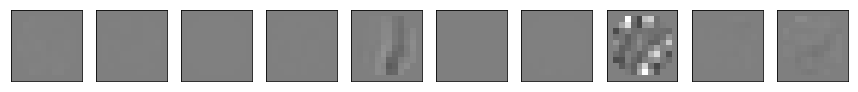

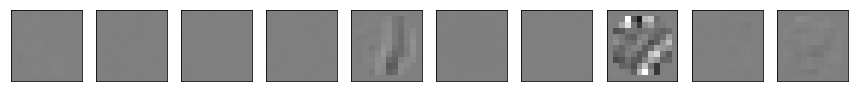

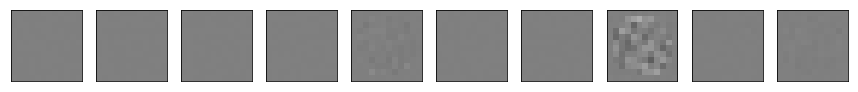

average of data patches =  -1.5845357615905582e-05 +/- 0.008061093893545403
average of residual patches =  -3.578871975122359e-05 +/- 0.002328609669689147
median energy of data =  0.03799767823484794
average energy of data =  0.06092893368629307 +/- 0.0648144893001244
average error =  -3.578871975122359e-05 +/- 0.025186512434274562
average energy of residual =  0.01767951488445884 +/- 0.017938685650975852
median energy of residual =  0.012051823103356677
average gain of coding =  3.7490097419654154 +/- 1.3323728880916683
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (256, 529)
average of codewords =  0.004282568162836684
l0-sparseness of codewords =  0.028296313799621928  ~= l0/M = 0.02835538752362949
average energy of codewords =  0.03702634620733879
std of the average of individual patches =  0.002872086432228176
number of codes, size of reconstructed images =  (256, 144)


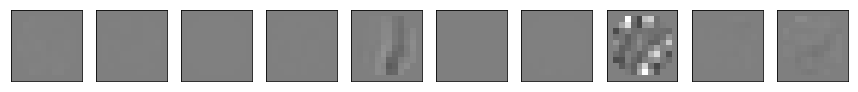

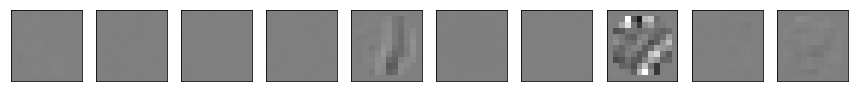

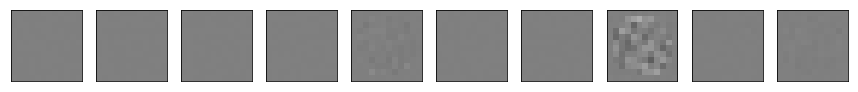

average of data patches =  -1.5845357615905582e-05 +/- 0.008061093893545403
average of residual patches =  -3.5788719751223496e-05 +/- 0.0023286096696891467
median energy of data =  0.03799767823484794
average energy of data =  0.06092893368629307 +/- 0.0648144893001244
average error =  -3.5788719751223496e-05 +/- 0.025186512434274565
average energy of residual =  0.01767951488445884 +/- 0.017938685650975852
median energy of residual =  0.012051823103356677
average gain of coding =  3.7490097419654154 +/- 1.332372888091668
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (256, 529)
average of codewords =  0.004288773653083587
l0-sparseness of codewords =  0.02832585066162571  ~= l0/M = 0.02835538752362949
average energy of codewords =  0.037200260831732446
std of the average of individual patches =  0.002768669793139975
number of codes, size of reconstructed images =  (256, 144)


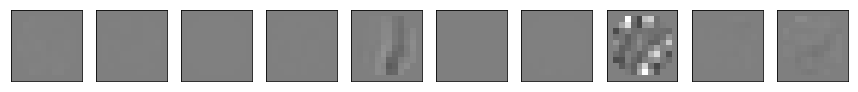

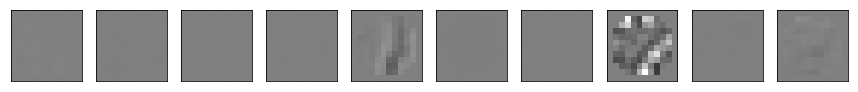

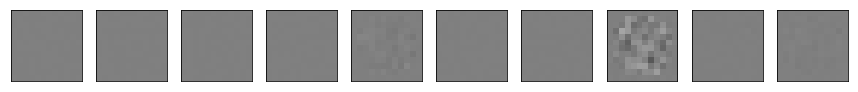

average of data patches =  -1.5845357615905582e-05 +/- 0.008061093893545403
average of residual patches =  -0.00035289888199170724 +/- 0.002581808833968643
median energy of data =  0.03799767823484794
average energy of data =  0.06092893368629307 +/- 0.0648144893001244
average error =  -0.00035289888199170724 +/- 0.025984394764463334
average energy of residual =  0.01810741849350308 +/- 0.01863960043556522
median energy of residual =  0.013331550717268225
average gain of coding =  3.7053808787219893 +/- 1.3559842999600784


In [11]:
from shl_scripts.shl_encode import mp
nb_quant = 128
record_num_batches = 256
np.random.seed(1973)
indx = np.random.permutation(data.shape[0])[:record_num_batches]
#sparse_code = shl.code(data, dico, matname=matname)
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))
#P_cum = dico.P_cum
#P_cum = None
l0_sparseness = 150
l0_sparseness = shl.l0_sparseness

for P_cum, gain in zip([None, P_cum_zeroeffect, dico.P_cum], [np.ones(shl.n_dictionary), None, None]):
    print(50*'🐒')
    sparse_code = mp(data[indx, :], dico.dictionary, l0_sparseness=l0_sparseness, P_cum=P_cum, gain=gain)

    print('number of codes, size of codewords = ', sparse_code.shape)
    print('average of codewords = ', sparse_code.mean())
    print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
    print('average energy of codewords = ', sparse_code.std(axis=0).mean())
    print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

    patches = sparse_code @ dico.dictionary
    print('number of codes, size of reconstructed images = ', patches.shape)

    from shl_scripts.shl_tools import show_data
    max_patches = 10
    fig, axs = show_data(data[indx, :][:max_patches, :])
    plt.show()
    fig, axs = show_data(patches[:max_patches, :])
    plt.show()
    
    error = (data[indx, :] - patches)
    fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(data[:max_patches, :])))
    plt.show()
    print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
    print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
    SD = np.sqrt(np.mean(data[indx, :]**2, axis=1))
    #SD = np.linalg.norm(data[indx, :])/record_num_batches

    print('median energy of data = ', np.median(SD))
    print('average energy of data = ', SD.mean(), '+/-', SD.std())
    #print('total energy of data = ', np.sqrt(np.sum(data**2)))
    #print('total deviation of data = ', np.sum(np.abs(data)))
    print('average error = ', error.mean(), '+/-', error.std())
    SE = np.sqrt(np.mean(error**2, axis=1))
    #SE = np.linalg.norm(error)/record_num_batches

    print('average energy of residual = ', SE.mean(), '+/-', SE.std())
    print('median energy of residual = ', np.median(SE))
    #print('total energy of residual = ', np.sqrt(np.sum(error**2)))
    #print('total deviation of residual = ', np.sum(np.abs(error)))
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())

## Quantization of the coefficients

In [12]:
from shl_scripts.shl_learn import get_P_cum
C = 5.
P_cum = get_P_cum(sparse_code, C=C, nb_quant=nb_quant)
P_cum.shape

(529, 128)

In [13]:
P_cum = dico.P_cum
P_cum.shape

(529, 128)

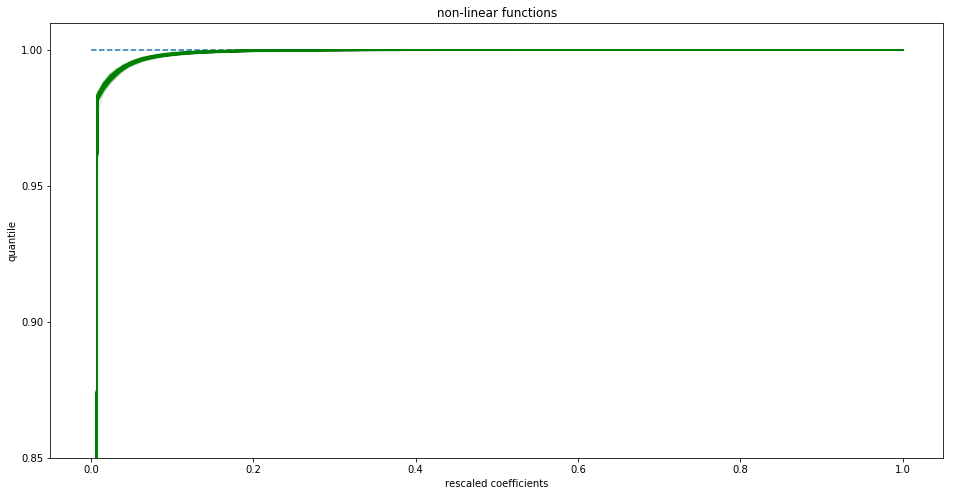

In [14]:
from shl_scripts.shl_tools import plot_P_cum
fig, ax = plot_P_cum(P_cum, verbose=False);
ax.set_ylim(0.85, 1.01);

In [15]:
P_cum.shape

(529, 128)

In [16]:
from shl_scripts.shl_encode import quantile, rescaling
#sparse_code = mp(data, dico.dictionary, l0_sparseness=l0_sparseness, P_cum=P_cum)
stick = np.arange(shl.n_dictionary)*nb_quant
q = quantile(P_cum, rescaling(sparse_code, C=C), stick, do_fast=True)

In [17]:
from shl_scripts.shl_encode import inv_quantile, inv_rescaling
q_sparse_code = inv_rescaling(inv_quantile(P_cum, q), C=C)
print('total deviation of coefficients = ', np.mean(np.abs(q_sparse_code-sparse_code)))

total deviation of coefficients =  3.5907974063216594e-05


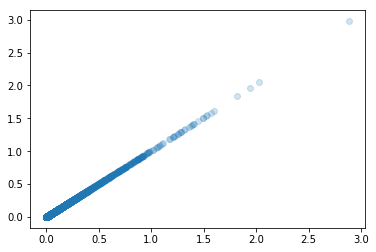

In [18]:
plt.scatter(sparse_code.ravel(), q_sparse_code.ravel(), alpha=.2);

In [19]:
P_cum.mean(axis=0).shape

(128,)

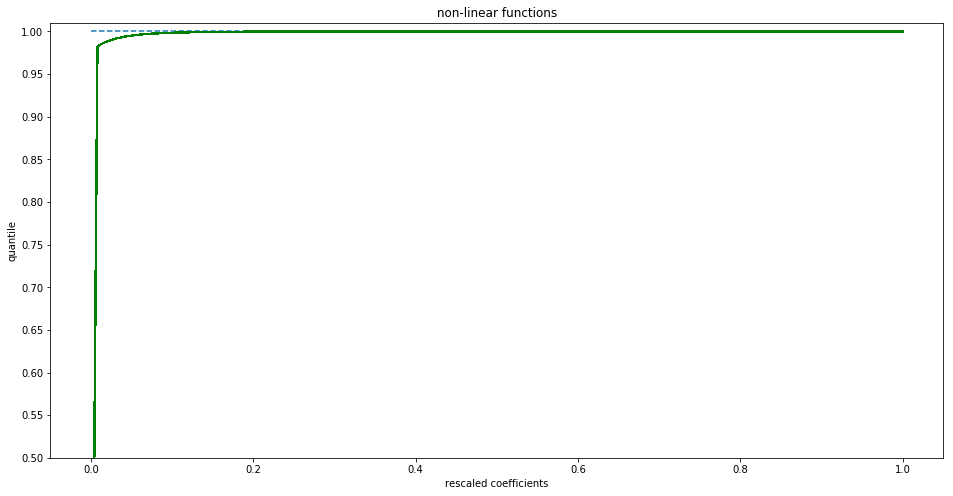

In [20]:
P_cum_mean = P_cum.mean(axis=0)[np.newaxis, :] * np.ones((shl.n_dictionary, nb_quant))
fig, ax = plot_P_cum(P_cum_mean, verbose=False);
ax.set_ylim(0.5, 1.01);

In [21]:
#q_sparse_code = inv_rescaling(inv_quantile(P_cum_mean, q), C=C)
q_sparse_code = inv_rescaling(inv_quantile(P_cum_mean, q), C=C)
print('total deviation of coefficients = ', np.mean(np.abs(sparse_code)))
print('total deviation of coefficients = ', np.mean(np.abs(q_sparse_code-sparse_code)))

total deviation of coefficients =  0.004288773653083587
total deviation of coefficients =  0.0003036020341784295


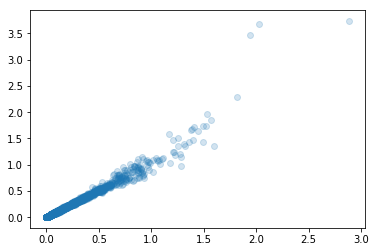

In [22]:
plt.scatter(sparse_code.ravel(), q_sparse_code.ravel(), alpha=.2);

average of data patches =  -1.5845357615905582e-05 +/- 0.008061093893545403
average of residual patches =  -0.0004057711225624489 +/- 0.0028751976310582095
median energy of data =  0.06671735009091605
average energy of data =  0.06671735009091605 +/- 0.0
average energy of residual =  0.023091948693191644 +/- 0.0
median energy of residual =  0.023091948693191644
average gain of coding =  2.889203980891694 +/- 0.0


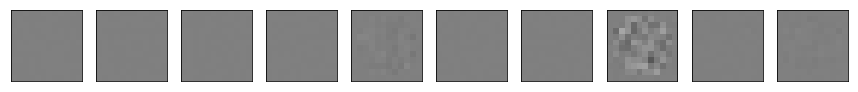

In [23]:
patches = q_sparse_code @ dico.dictionary
error = data[indx, :] - patches
fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(data[:max_patches, :])))
print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
#SD = np.sqrt(np.mean(data[indx, :]**2, axis=1))
SD = np.linalg.norm(data[indx, :])/record_num_batches
print('median energy of data = ', np.median(SD))
print('average energy of data = ', SD.mean(), '+/-', SD.std())
#print('total energy of data = ', np.sqrt(np.sum(data**2)))
#print('total deviation of data = ', np.sum(np.abs(data)))
#SE = np.sqrt(np.mean(error**2, axis=1))
SE = np.linalg.norm(error)/record_num_batches

print('average energy of residual = ', SE.mean(), '+/-', SE.std())
print('median energy of residual = ', np.median(SE))
#print('total energy of residual = ', np.sqrt(np.sum(error**2)))
#print('total deviation of residual = ', np.sum(np.abs(error)))
print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())

In [24]:
P_cum[0, -2]

0.999999999999999

## Version used

In [25]:
%load_ext version_information
%version_information numpy, shl_scripts

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.1
shl_scripts 20171221
Wed Feb 21 21:20:55 2018 CET